<a href="https://colab.research.google.com/github/Lchet/playground-examples/blob/main/cGAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Abstract
The purpose of the notebook is to build an cGAN model for audio signals.

Given 4 one-dimensional audio signals, this notebook outlines a cGAN model architecture for generating one of the signal, conditioned on one of the other 3 signals. 
The proposed architecture is realized using TensorFlow.

#Approach

Let's consider our 4 signals as $s_1, s_2, s_3, s_4$ respectively. We can think of those signals as representing different instruments and sharing the same notes.
Let's assume that we need to generate $s_1$ from $s_2$, $s_3$ and $s_4$.
Our generator - $G$ should be able to generate the $s_1$ given $s_2$, $s_3$ and $s_4$. $G$ should be trained in a way that would enable it to decode embedding information of $s_2$, $s_3$ and $s_4$ and generate same tones but according to instrument - $s_1$.


1.   How do we encode/embed characteristic/context of $s_2$, $s_3$ and $s_4$?
2.   What would be our $cGAN$ model architecture to enable $G$ to generate missing signal ($s_1$)





## 1. Embedding signal information
There are several approaches to retrieve the signals characteristics, I will use FT convert $s_1, s_2, s_3, s_4$ to frequency domain and to time frequency domain. This transformations would provide us with spectral signal characteristics that define the signals in time and frequency. The main issue with this conversion is that we might lose phase information, however, make use of neural net might still capture it. 
In this scope, I am assuming existence of a given *Class* that provides the MMCS and Spectrogram transformation, there are many libraries that provides such audio signal manipulation, one of them is [***Librosa***](https://librosa.org/doc/0.9.1/tutorial.html)



## 2. cGAN model architecture
Let denote $s_i$ and $s_j$ the input signal and the target signal we want to generate
$cGAN$ is the model that I will discuss hereunder

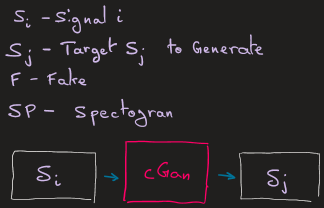

Let's couple each $s_i$ ($i=1,2,3,4$) with its relevant spectrogram image that is denoted as $sc_i$ for *Signal Characteristic*.
So we have coupled items $(s_i, sc_i)$ for each $i$.

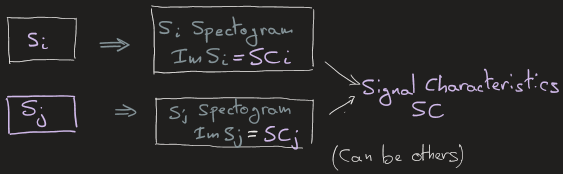

The following described the high-level flow:
1. Input to our *Generator* $G$ signals $s_i$ from our dataset (in our case 4 possibilities) the label index of the desired signal to be generated let's say - $j$ to generate $s_j$.
2. Internal layers perform a standard transformation to spectrogram for signal input $s_i$  
2. The *Generator* $G$ generate a signal $fs_j$ which is fake (at least in the first training iterations)
3. We will measure the $MAE$ loss (the mean absolute distance of the generated signal from the real signal) of $fs_j$ with the real $s_j$. This loss will be added to the other loss of the all *GAN* *Generator* model that I will shortly explain.
4. Next, the *Discriminator* $D$ gets $2$ tuples: $(s_j, sc_j)$, $(fs_j, fcs_j)$ and concatinate them channel wise
5. $D$ runs through a *PatchGAN CNN* as proposed in [*pix2pix paper*](https://arxiv.org/abs/1611.07004) and outputs True/False with *Binary CrossEntropy loss - BCE* 


### $G$ - ***Generator***
1. Get $(s_i, cs_i)$ concatinate them channel-wise to a 4-channel img,
> we might add some randomize noise as well.
2. Run the 4-channel img through an UNET like network to out put a 4-channel img.
3. The 4-channel img is beeing sperated to $Fcs_j$ and $Fs_j$ - fake outputs
4. MSA/MSE loss will be calculated abnd added to the *BCE* loss above of the *Discriminator* - $D$






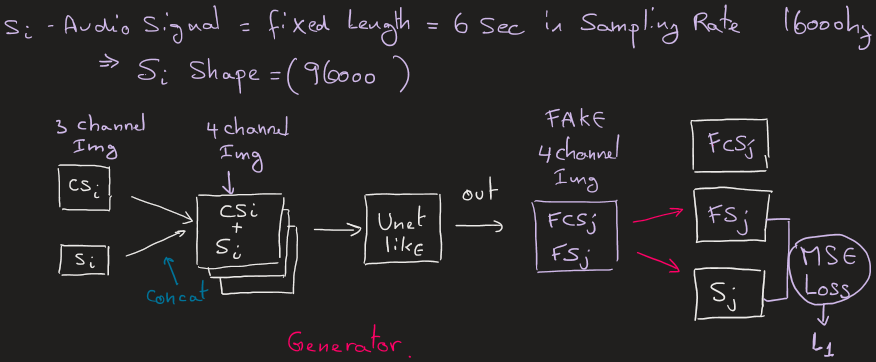

### $D$ - ***Discriminator***
1. Get $(Fcs_j, Fs_j)$, $(cs_j, s_j)$ and concatinates each tuple to a 4 channel img resultin with 2 img x 4 channels each
2. Runs through a *Path_GAN CNN* and finally output a binary classification
3. *BCE* loss is beeing added with a weight to MAE loss of above with a ration of 1:100.

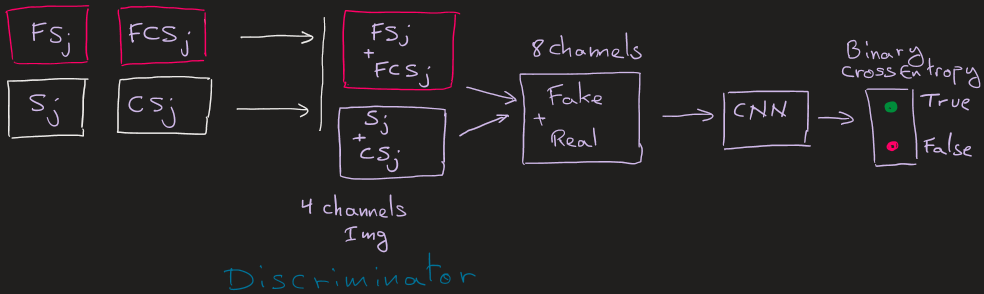

### Traing process - high level
The Following picture is taken from orig paper of PixPix to describe the training process

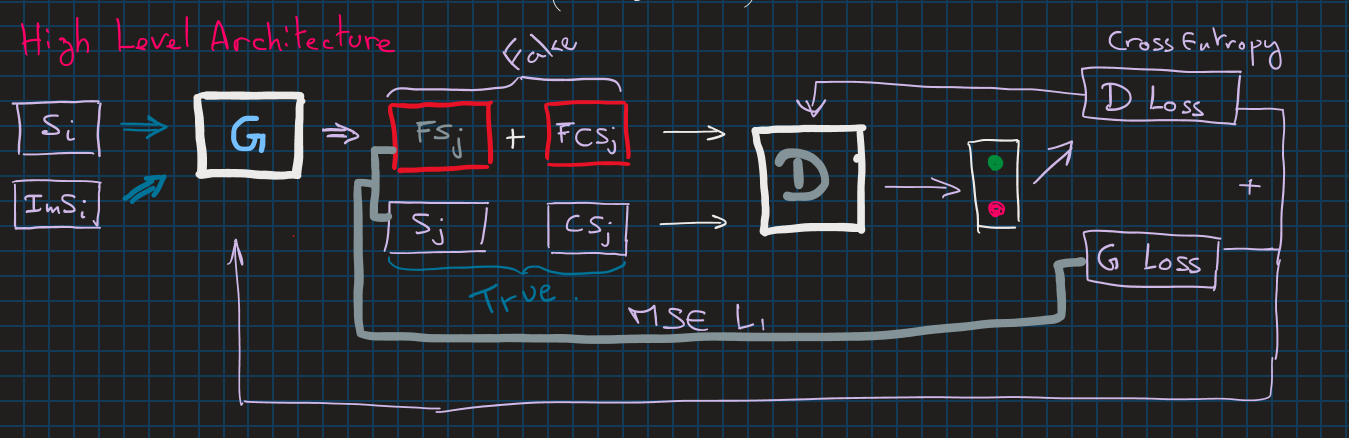

![Discriminator Update Image](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/dis.png?raw=1)


In [1]:
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
# Load in sounds
nutcracker, sr = librosa.load(librosa.example('nutcracker'))
trumpet, _ = librosa.load(librosa.example('trumpet'))
vibeace, _ = librosa.load(librosa.example('vibeace'))

In [2]:
def to_decibles(signal):
    # Perform short time Fourier Transformation of signal and take absolute value of results
    stft = np.abs(librosa.stft(signal))
    # Convert to dB
    D = librosa.amplitude_to_db(stft, ref = np.max) # Set reference value to the maximum value of stft.
    return D # Return converted audio signal

# Function to plot the converted audio signal
def plot_spec(D, sr, instrument):
    fig, ax = plt.subplots(figsize = (30,10))
    spec = librosa.display.specshow(D, sr=sr, x_axis='time', y_axis='linear', ax=ax)
    ax.set(title = 'Spectrogram of ' + instrument)
    fig.colorbar(spec)

In [3]:
D = to_decibles(trumpet)

In [10]:
D.shape

(1025, 230)

In [ ]:
librosa.stft()

In [12]:
trumpet.shape

(117601,)

In [13]:
sr

22050

In [14]:
117601/sr

5.333378684807256

In [18]:
117601/1025

114.73268292682927

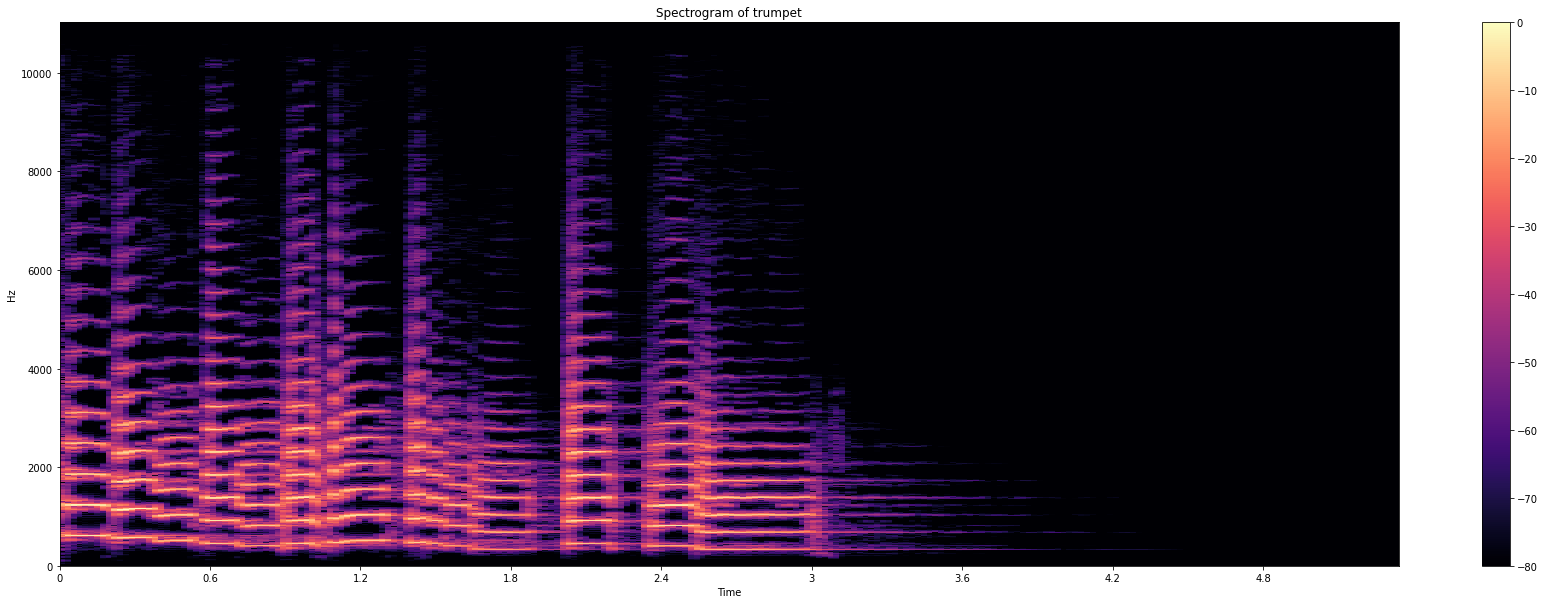

In [90]:
plot_spec(to_decibles(trumpet), sr, 'trumpet')

In [3]:
librosa.util.list_examples()

AVAILABLE EXAMPLES
--------------------------------------------------------------------
brahms    	Brahms - Hungarian Dance #5
choice    	Admiral Bob - Choice (drum+bass)
fishin    	Karissa Hobbs - Let's Go Fishin'
nutcracker	Tchaikovsky - Dance of the Sugar Plum Fairy
trumpet   	Mihai Sorohan - Trumpet loop
vibeace   	Kevin MacLeod - Vibe Ace


#Implementation

## Global Params

In [4]:
from operator import attrgetter
class HParams(object):
   def __init__(self, **kwargs):
        self.__dict__.update(kwargs)
   @property
   def signal_shape(self):
     return (256*256, )

In [172]:
hparams = HParams( 
    batch_size = 1,
    # 16,000 hz
    sample_rate = 20,
    # 6 seconds
    audio_length = 6, 
    create_spectrogram = True,
    win_length = 1024,
    n_fft = 1024,
    hop_length= 400,
    ref_level_db = 50,
    min_level_db = -100,
    # mel scaling
    num_mel_bins = 128,
    mel_lower_edge_hertz = 0,
    mel_upper_edge_hertz = 8000,
    # spetogram image
    spectrogram_shape = (256, 256, 3),
    )

## Import Libraries

In [174]:
import tensorflow as tf

tfk = tf.keras
tfkl = tfk.layers

conv_init = tf.keras.initializers.RandomNormal(
  mean=0.0, stddev=0.02
)

mae = tfk.losses.MeanAbsoluteError()
bce = tfk.losses.BinaryCrossentropy()


## Discriminator

In [179]:
def create_discriminator(spectrogram_shape,
                         signal_shape):
    
	    
  # Spectrogram source image input we want to convert - cs_i
  cs_i = tfkl.Input(shape=spectrogram_shape, name="cs_i")  
  # source signal input we want to convert - s_i
  s_i = tfkl.Input(shape=signal_shape, name="s_i")  
  sig_i =tfkl.Reshape(hparams.spectrogram_shape[:-1]+(1,))(s_i)

  # target sepctrogram image input we want to generate- cs_j
  cs_j = tfkl.Input(shape=spectrogram_shape, name="cs_j (target)") 
  # target signal input we want to generate- s_j
  s_j = tfkl.Input(shape=signal_shape, name="s_j (target)") 
  sig_j =tfkl.Reshape(hparams.spectrogram_shape[:-1]+(1,))(s_j)
    
  # concatenate cs spectrogram image and s signal, channel-wise
  merged_i = tfkl.Concatenate(name="source_i")([cs_i, sig_i])
  merged_j = tfkl.Concatenate(name="target_j")([cs_j, sig_j])

  # concatenate both input signal and target, channel-wise
  merged = tfkl.Concatenate(name="source_target")([merged_i, merged_j])

  # C64: 4x4 kernel Stride 2x2
  # receptive field = (70-1)*2 + 4 = 142
  d = tfkl.Conv2D(64, (4,4), strides=(2,2), padding='same', 
                  kernel_initializer=conv_init)(merged)
  d = tfkl.LeakyReLU(alpha=0.2)(d)
  # C128: 4x4 kernel Stride 2x2
  # receptive field = (34-1)*2 + 4 = 70
  d = tfkl.Conv2D(128, (4,4), strides=(2,2), 
                  padding='same', 
                  kernel_initializer=conv_init)(d)
  d = tfkl.BatchNormalization()(d)
  d = tfkl.LeakyReLU(alpha=0.2)(d)
  # C256: 4x4 kernel Stride 2x2
  # receptive field = (16-1)*2 + 4 = 34
  d = tfkl.Conv2D(256, (4,4), strides=(2,2), padding='same', 
                  kernel_initializer=conv_init)(d)
  d = tfkl.BatchNormalization()(d)
  d = tfkl.LeakyReLU(alpha=0.2)(d)
  # # C512: 4x4 kernel Stride 2x2 
  # receptive field = (7-1)*2 + 4 = 16
  d = tfkl.Conv2D(512, (4,4), strides=(2,2), padding='same', 
                  kernel_initializer=conv_init)(d)
  d = tfkl.BatchNormalization()(d)
  d = tfkl.LeakyReLU(alpha=0.2)(d)
  # last output layer : 4x4 kernel but Stride 1x1
  # receptive field = (4-1)*1 + 4 = 7
  d = tfkl.Conv2D(512, (4,4), padding='same', 
                  kernel_initializer=conv_init)(d)
  d = tfkl.BatchNormalization()(d)
  d = tfkl.LeakyReLU(alpha=0.2)(d)
  # patch output
  # receptive field = (1-1)*1 + 4 = 4
  patch_out = tfkl.Conv2D(1, (4,4), padding='same', 
                  kernel_initializer=conv_init, activation='sigmoid')(d)
  
  # define model
  model = tfk.Model(inputs=[cs_i, s_i, cs_j, s_j], 
                    outputs=patch_out,
                    name='discriminator')
  # compile model
    
  opt = tfk.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)
  model.compile(loss=bce, optimizer=opt, loss_weights=[0.5])
  return model


Model: "discriminator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 s_i (InputLayer)               [(None, 65536)]      0           []                               
                                                                                                  
 s_j (target) (InputLayer)      [(None, 65536)]      0           []                               
                                                                                                  
 cs_i (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape_79 (Reshape)           (None, 256, 256, 1)  0           ['s_i[0][0]']        

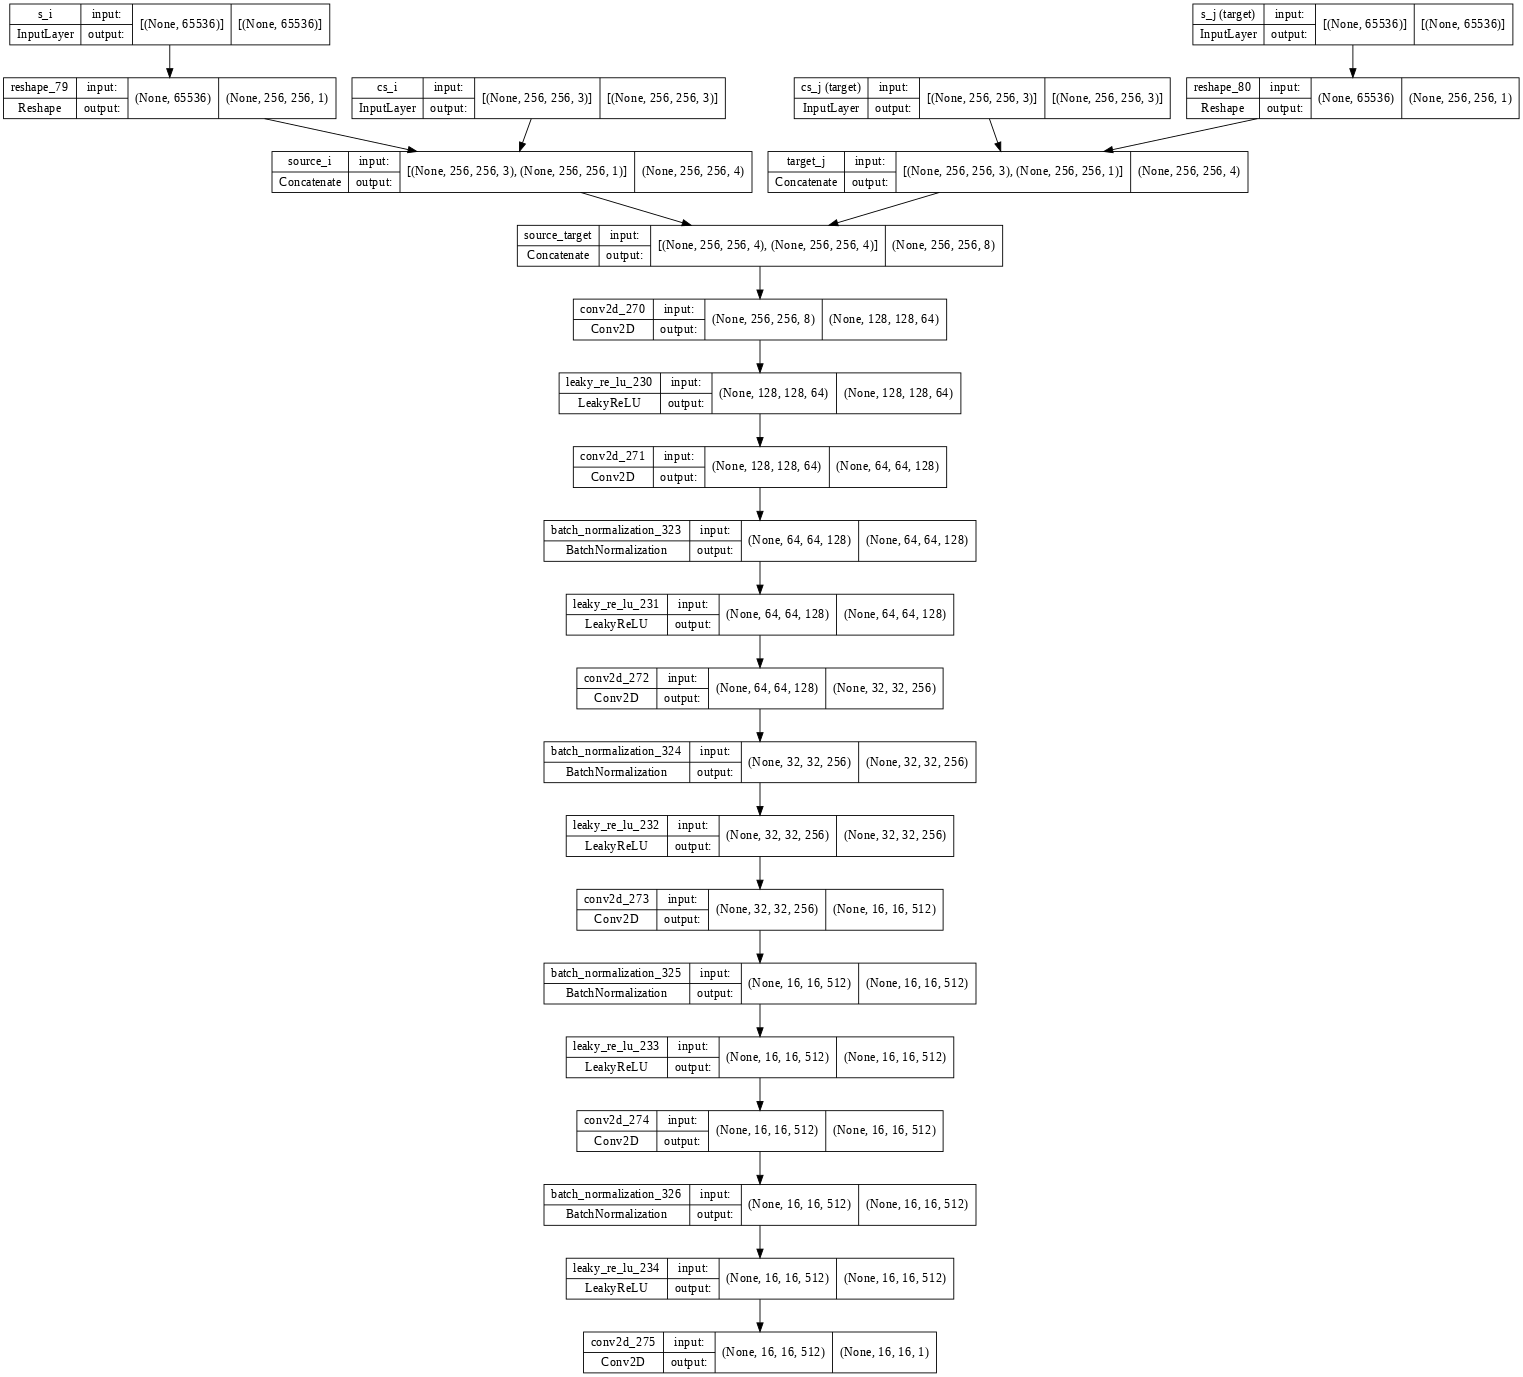

In [180]:
d_model = create_discriminator(hparams.spectrogram_shape, 
                               hparams.signal_shape)
d_model.summary()
tfk.utils.plot_model(d_model, show_shapes=True, dpi=64)

In [181]:
d_model.output

<KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'conv2d_275')>

##Generator

In [182]:
# define an u-net encoder block to be used in generator
def encoder_block(layer_in, n_filters, batchnorm=True):
  
  # add downsampling layer
  enc_gen_block = tfkl.Conv2D(n_filters, (4,4), strides=(2,2), padding='same',
                  kernel_initializer=conv_init)(layer_in)
  # conditionally add batch normalization
  if batchnorm:
    enc_gen_block = tfkl.BatchNormalization()(enc_gen_block, training=True)
  # leaky relu activation
  g = tfkl.LeakyReLU(alpha=0.2)(enc_gen_block)
  return enc_gen_block

# define a u-net decoder block to be used in generator
def decoder_block(layer_in, skip_in, n_filters, dropout=True):
  
  # add upsampling layer
  dec_gen_block = tfkl.Conv2DTranspose(n_filters, (4,4), strides=(2,2), 
                                  padding='same', kernel_initializer=conv_init)(layer_in)
  # add batch normalization
  dec_gen_block = tfkl.BatchNormalization()(dec_gen_block, training=True)
  # conditionally add dropout
  if dropout:
    dec_gen_block = tfkl.Dropout(0.5)(dec_gen_block, training=True)
  # merge with skip connection
  dec_gen_block = tfkl.Concatenate()([dec_gen_block, skip_in])
  # relu activation
  dec_gen_block = tfkl.Activation('relu')(dec_gen_block)
  return dec_gen_block

In [87]:
s_i

<KerasTensor: shape=(None, 65536) dtype=float32 (created by layer 'input_1')>

In [183]:
# define the standalone generator model - U-net
def create_generator(spectrogram_shape, signal_shape):
	
  # Spectrogram source image input we want to convert - cs_i
  cs_i = tfkl.Input(shape=spectrogram_shape, name="cs_i")  
  # source signal input we want to convert - s_i
  s_i = tfkl.Input(shape=signal_shape, name="s_i")  
  sig_i =tfkl.Reshape(hparams.spectrogram_shape[:-1]+(1,))(s_i)

  # concatenate cs spectrogram image and s signal, channel-wise
  merged_i = tfkl.Concatenate(name="source_i")([cs_i, sig_i])

  # U-NET like:
  # encoder model: C64-C128-C256-C512-C512-C512-C512-C512
  e1 = encoder_block(merged_i, 64, batchnorm=False)
  e2 = encoder_block(e1, 128)
  e3 = encoder_block(e2, 256)
  e4 = encoder_block(e3, 512)
  e5 = encoder_block(e4, 512)
  e6 = encoder_block(e5, 512)
  e7 = encoder_block(e6, 512)
  # bottleneck, no batch norm and relu
  b = tfkl.Conv2D(512, (4,4), strides=(2,2), padding='same', 
                  kernel_initializer=conv_init)(e7)
  b = tfkl.Activation('relu')(b)
  # decoder model: CD512-CD512-CD512-C512-C256-C128-C64
  d1 = decoder_block(b, e7, 512)
  d2 = decoder_block(d1, e6, 512)
  d3 = decoder_block(d2, e5, 512)
  d4 = decoder_block(d3, e4, 512, dropout=False)
  d5 = decoder_block(d4, e3, 256, dropout=False)
  d6 = decoder_block(d5, e2, 128, dropout=False)
  d7 = decoder_block(d6, e1, 64, dropout=False)

  # output
  d8 = tfkl.Conv2DTranspose(1, 
                            (4,4), 
                            strides=(2,2), 
                            padding='same', 
                            kernel_initializer=conv_init, 
                            activation='tanh')(d7)
  gen_out =tfkl.Reshape(hparams.signal_shape)(d8)
  
  # define model
  model = tfk.Model(inputs=[cs_i, s_i], outputs=[gen_out], name='generator')
  return model

In [184]:
s_i.shape


TensorShape([None, 65536])

Model: "generator"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 s_i (InputLayer)               [(None, 65536)]      0           []                               
                                                                                                  
 cs_i (InputLayer)              [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 reshape_81 (Reshape)           (None, 256, 256, 1)  0           ['s_i[0][0]']                    
                                                                                                  
 source_i (Concatenate)         (None, 256, 256, 4)  0           ['cs_i[0][0]',           

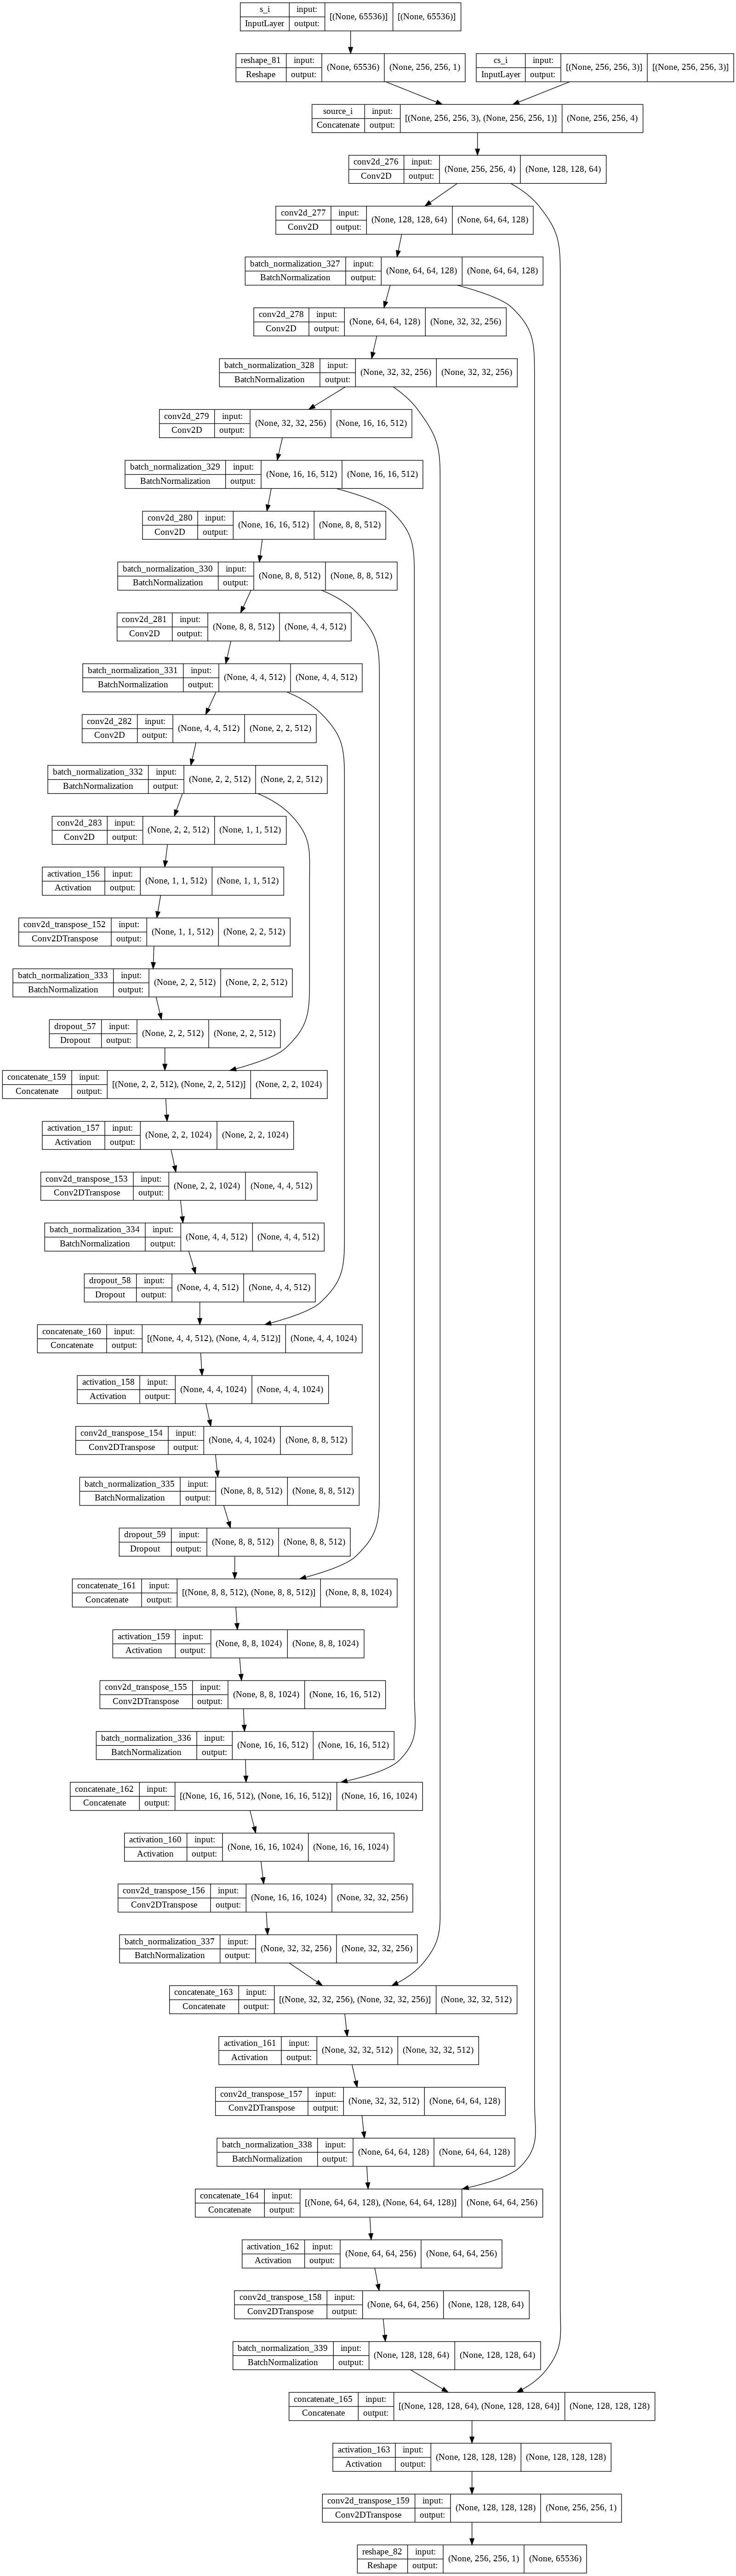

In [185]:
g_model = create_generator(hparams.spectrogram_shape, hparams.signal_shape)
g_model.summary()
tfk.utils.plot_model(g_model, to_file='gen_model.png', show_shapes=True)

In [154]:
g_model.name

'generator'

###cGAN

In [57]:
d_model.input

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'cs_i')>,
 <KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_48')>,
 <KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'cs_j (target)')>,
 <KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_49')>]

In [76]:
g_model.output

<KerasTensor: shape=(None, 65536) dtype=float32 (created by layer 'reshape_36')>

In [68]:
g_model.input

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'cs_i')>,
 <KerasTensor: shape=(None, 256, 256, 1) dtype=float32 (created by layer 'input_55')>]

In [77]:
d_model.output

<KerasTensor: shape=(None, 16, 16, 1) dtype=float32 (created by layer 'conv2d_51')>

In [78]:
in_src = [cs_i, s_i]

In [79]:
in_src

[<KerasTensor: shape=(None, 256, 256, 3) dtype=float32 (created by layer 'input_2')>,
 <KerasTensor: shape=(None, 65536) dtype=float32 (created by layer 'input_1')>]

In [192]:
class cGAN():
    """
    
    """
    def __init__(self):
        """
        The class initializes according to a given default spectrogram image shape and signal shape.
        The model is trained on a given assumed spectrogram shape and a signal shape
        Signal of different lengths would be pre-processed and arranged (by trimming or by padding) to 
        provide the expected shape
        """
               
        # create discriminator, spectrogram_shape refers to signal spectrogram shape,
        self.d_model = create_discriminator( hparams.spectrogram_shape, 
                                             hparams.signal_shape)
        # create generator, spectrogram_shape refers to signal spectrogram shape,
        self.g_model = create_generator(hparams.spectrogram_shape, 
                                        hparams.signal_shape)

        self.cgan_model = self._create_cgan_model(self.d_model, self.g_model)

          
    
    def _create_cgan_model(self, d_model, g_model):
        """
        create the cgan model based on the discriminator model = d_model
        and generator model = g_model
        @param d_model: discriminator
        @param g_model: generator
        @return: 
        """
        # Discriminator layers set to un-trainable in the combined GAN
        # However, standalone discriminator will be trainable.
        for layer in d_model.layers:
            if not isinstance(layer, tfkl.BatchNormalization):
                layer.trainable = False

        # define the source signal and spectrogram
        cs_i = tfkl.Input(shape=hparams.spectrogram_shape, name="spectro_i")
        # source signal input we want to convert - s_i
        s_i = tfkl.Input(shape=hparams.signal_shape, name="signal_i")
        # source signal input we want to convert - s_i
        s_j = tfkl.Input(shape=hparams.signal_shape, name="signal_j")

        # input to generator
        gen_in = [cs_i, s_i]
        # suppy the source as input to the generator
        gen_out = g_model(gen_in)

        # input to discriminator
        discr_in = gen_in + [cs_i, gen_out]
        # supply the inputs source and target source (signal + spectrogram)
        # as inputs to the discriminator
        dis_out = d_model(discr_in)

        # src signal and spectrogram as input
        # generated signal and discriminator output as outputs
        cgan_model = tfk.Model(inputs=gen_in,
                               outputs=[dis_out, gen_out],
                               name='cGAN')
        # compile model
        opt = tfk.optimizers.Adam(learning_rate=0.0002, beta_1=0.5)

        # Total loss is the weighted sum of adversarial loss (BCE) and L1 loss (MAE)
        # Authors suggested weighting BCE vs L1 as 1:100.
        cgan_model.compile(loss=[bce, mae],
                           optimizer=opt,
                           loss_weights=[1, 100])
        return cgan_model

    def summary(self):
        self.cgan_model.cgan_model.summary()

    def plot(self):
        tfk.utils.plot_model(self.cgan_model,
                             to_file='gen_model.png',
                             show_shapes=True)

    def train(self, dataset, epochs=100, batch_size=1):
        """
        train the combined gan model
        @param dataset: tf.dataset type that contains pairs of (source, target) signals 
        @param epochs: 
        @param batch_size: 
        @return: 
        """

        # get the patch size output shape from the discriminator
        patch_shape = self.d_model.output_shape[1]
        # unpack dataset
        signalSource, singalTarget = dataset
        # calculate the number of batches per training epoch
        batches_per_epo = int(len(singalSource) / batch_size)
        # calculate the number of iterations
        iterations = batches_per_epo * epochs
        # manually enumerate epochs
        for i in range(iterations):

            # get real source and targetsignals batches
            [signals_S, signals_T], y_real = self._get_real_samples(dataset,
                                                                batch_size,
                                                                patch_shape)

            # generate fake target signals batches
            signals_fakeT, y_fake = self._generate_fake_samples(self.g_model,
                                                          signals_S,
                                                          patch_shape)
            # update discriminator for real samples
            d_loss1 = self.d_model.train_on_batch([signals_S, signals_T], 
                                                  y_real)
            # update discriminator for generated samples
            d_loss2 = self.d_model.train_on_batch([signals_S, signals_fakeT],
                                                  y_fake)
            # update the generator
            g_loss, _, _ = self.cgan_model.train_on_batch(signals_S, 
                                                          [y_real, signals_fakeT])
            # summarize performance
            print(f'>%d, d1[%.3f] d2[%.3f] g[%.3f]' % (i + 1, 
                                                       d_loss1, 
                                                       d_loss2, 
                                                       g_loss))
            # save the generator model
            if (i+1) % (batches_per_epoch * 10) == 0:
              model_filename = 'g_model_%06d.h5' % (i)
              self.g_model.save(model_filename)
        pass

    def _generate_real_samples(self, dataset, batch_size, patch_shape):
      """
      
      @param dataset: 
      @param batch_size: 
      @param patch_shape: 
      @return: 
      """
      # unpack dataset to 
      # source signals - trainS, target signals - trainT 
      trainS, trainT = dataset
      # choose random instances
      indx = np.random.randint(0, trainS.shape[0], batch_size)

      # retrieve source signals and target signals
      s_source, s_target = trainS[indx], trainT[indx]
      # generate 'real' class labels (1)
      y = np.ones((batch_size, patch_shape, patch_shape, 1))
      return [s_source, s_target], y


    def _generate_fake_samples(self, signals, patch_shape):
      """
      generate fake signals from signals
      @param signals: input signals from which to generate target signals 
      @param patch_shape: 
      @return: 
      """
      # generate fake instance
      f_target = g_model.predict(signals)
      # create 'fake' class labels (0)
      y = np.zeros((len(f_target), patch_shape, patch_shape, 1))
      return f_target, y


In [193]:
c_gan = cGAN()

In [194]:
c_gan.cgan_model.summary()

Model: "cGAN"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 spectro_i (InputLayer)         [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 signal_i (InputLayer)          [(None, 65536)]      0           []                               
                                                                                                  
 generator (Functional)         (None, 65536)        54426241    ['spectro_i[0][0]',              
                                                                  'signal_i[0][0]']               
                                                                                               

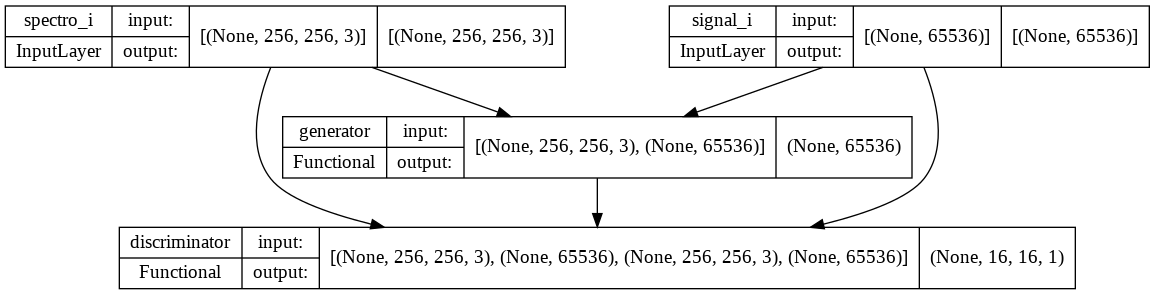

In [195]:
tfk.utils.plot_model(c_gan.cgan_model, to_file='gen_model.png', show_shapes=True)

# playing with audio

There should be another class to build and convert audio samples to images
I didn't develop this class yet.../

In [30]:
import numpy as np, scipy, matplotlib.pyplot as plt, sklearn, librosa, urllib, IPython.display
import librosa.display
# import essentia, essentia.standard as ess
plt.rcParams['figure.figsize'] = (14,4)


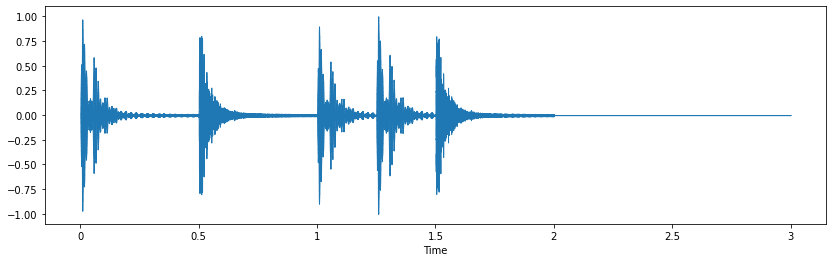

In [23]:
file_sample = '/content/drive/MyDrive/Colab Notebooks/DCGAN/simple_loop.wav'
x, fs = librosa.load(file_sample)

librosa.display.waveshow(x, sr=fs)

In [58]:
IPython.display.Audio(x, rate=fs)

In [27]:
mfccs = librosa.feature.mfcc(x, sr=fs)
print(f"mfccs shape is: {mfccs.shape}, audio signal is: {x.shape}, frequency sample: {fs}")

mfccs shape is: (20, 130), audi signal is: (66150,), frequency sample: 22050


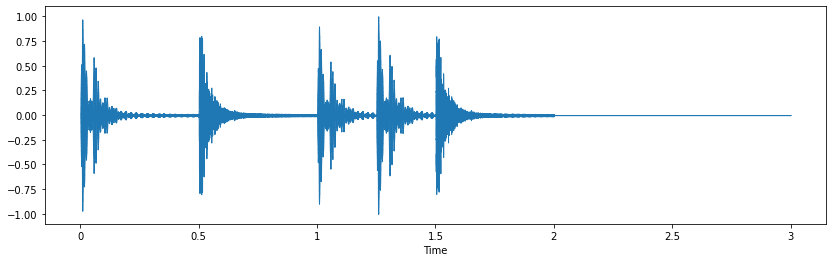

In [21]:
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

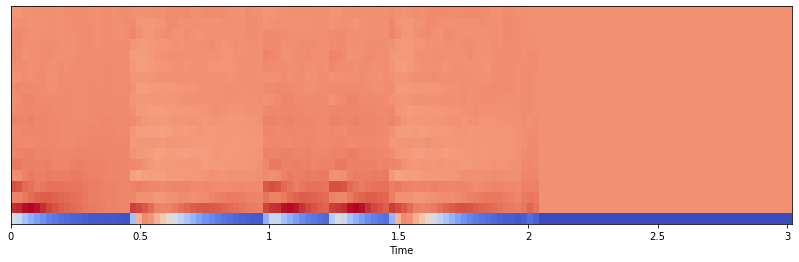

In [36]:
librosa.display.specshow(mfccs, sr=fs, x_axis='time')

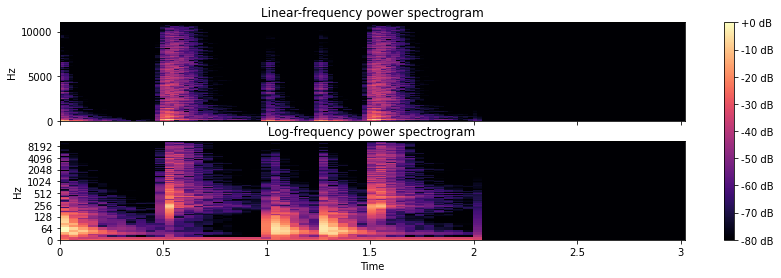

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=True)
D = librosa.amplitude_to_db(np.abs(librosa.stft(x)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',
                               sr=fs, ax=ax[0])
ax[0].set(title='Linear-frequency power spectrogram')
ax[0].label_outer()

hop_length = 1024
D = librosa.amplitude_to_db(np.abs(librosa.stft(x, hop_length=hop_length)),
                            ref=np.max)
librosa.display.specshow(D, y_axis='log', sr=fs, hop_length=hop_length,
                         x_axis='time', ax=ax[1])
ax[1].set(title='Log-frequency power spectrogram')
ax[1].label_outer()
fig.colorbar(img, ax=ax, format="%+2.f dB")

In [ ]:
D.shape

In [ ]:
class MelSpec(layers.Layer):
    def __init__(
        self,
        frame_length=1024,
        frame_step=256,
        fft_length=None,
        sampling_rate=22050,
        num_mel_channels=80,
        freq_min=125,
        freq_max=7600,
        **kwargs,
    ):
        super().__init__(**kwargs)
        self.frame_length = frame_length
        self.frame_step = frame_step
        self.fft_length = fft_length
        self.sampling_rate = sampling_rate
        self.num_mel_channels = num_mel_channels
        self.freq_min = freq_min
        self.freq_max = freq_max
        # Defining mel filter. This filter will be multiplied with the STFT output
        self.mel_filterbank = tf.signal.linear_to_mel_weight_matrix(
            num_mel_bins=self.num_mel_channels,
            num_spectrogram_bins=self.frame_length // 2 + 1,
            sample_rate=self.sampling_rate,
            lower_edge_hertz=self.freq_min,
            upper_edge_hertz=self.freq_max,
        )

    def call(self, audio, training=True):
        # We will only perform the transformation during training.
        if training:
            # Taking the Short Time Fourier Transform. Ensure that the audio is padded.
            # In the paper, the STFT output is padded using the 'REFLECT' strategy.
            stft = tf.signal.stft(
                tf.squeeze(audio, -1),
                self.frame_length,
                self.frame_step,
                self.fft_length,
                pad_end=True,
            )

            # Taking the magnitude of the STFT output
            magnitude = tf.abs(stft)

            # Multiplying the Mel-filterbank with the magnitude and scaling it using the db scale
            mel = tf.matmul(tf.square(magnitude), self.mel_filterbank)
            log_mel_spec = tfio.audio.dbscale(mel, top_db=80)
            return log_mel_spec
        else:
            return audio

    def get_config(self):
        config = super(MelSpec, self).get_config()
        config.update(
            {
                "frame_length": self.frame_length,
                "frame_step": self.frame_step,
                "fft_length": self.fft_length,
                "sampling_rate": self.sampling_rate,
                "num_mel_channels": self.num_mel_channels,
                "freq_min": self.freq_min,
                "freq_max": self.freq_max,
            }
        )
        return config